## Basic Co-Occurrence Analysis of Human-Cell-Atlas Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn_image as isns
import seaborn as sns
import scipy.signal as signal
from scipy import stats

import statsmodels.stats.multitest as smm

from sonar import sonar, utils
import math
import random

from distinctipy import distinctipy

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from skimage import io
from PIL import Image



In [3]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'

# Upload sample, define labels

# Geodata

In [4]:
relevant_cluster_labels = "sparse vegetation", "dry cryptogramic-crust", "gramnoid", "dry to moist", 
"moist to wet", "wet to waterlogged", "moist low density", "tall shrubs", "mixed forest", "coniferous", 
"meadows", "wet ecotops", "disturbed", "floodplain fuvial", "floodplain lacustrine", "seasonally inundated", 
"barren rare", "barren artificial", "water shallow", "water medium", "water deep", "background"

('barren rare',
 'barren artificial',
 'water shallow',
 'water medium',
 'water deep',
 'background')

In [5]:
# Open the image
image = Image.open('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/geodata/image.png')

# Convert RGBA to RGB
rgb_image = image.convert('RGB')

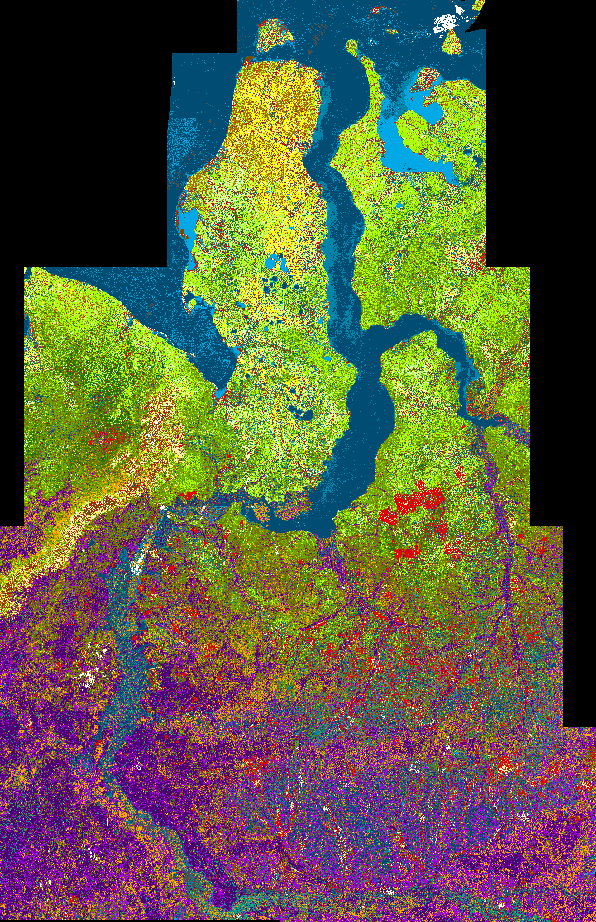

In [6]:
image

In [7]:
rgb_image = np.array(rgb_image)

In [8]:
# Reshape the array to a 2D array of pixels (height * width, channels)
pixels = rgb_image.reshape((-1, 3))

# Find unique colors
unique_colors = np.unique(pixels, axis=0)

In [9]:
# Create an empty 3D tensor with the shape of the original image
integer_map = np.zeros((rgb_image.shape[0], rgb_image.shape[1],len(unique_colors)), dtype=int)

# Iterate through the unique color values and assign index values to the tensor
for index, color in enumerate(unique_colors):
    condition = np.all(rgb_image == color[np.newaxis, np.newaxis, :], axis=2)
    integer_map[condition,index] = 1  # Adding 1 to start indices from 1
    # integer_map = integer_map.astype(int) # converting bool array to an int array
integer_map = integer_map.transpose(2, 0, 1) # switching shape to the manner that is required for sonar

In [10]:
unique_colors

array([[  0,   0,   0],
       [  0,  76, 115],
       [  0, 132, 168],
       [  0, 168, 132],
       [  0, 169, 230],
       [ 38, 115,   0],
       [ 76,   0, 115],
       [ 78,  78,  78],
       [104, 104, 104],
       [112, 168,   0],
       [115,  76,   0],
       [115, 115,   0],
       [130, 130, 130],
       [132,   0, 168],
       [168, 112,   0],
       [169,   0, 230],
       [170, 255,   0],
       [211, 255, 190],
       [230,   0,   0],
       [255, 170,   0],
       [255, 235, 175],
       [255, 255,   0],
       [255, 255, 255]], dtype=uint8)

In [11]:
# List of colors in hex format
hex_colors = ["ffebaf", "ffff00", "d3ffbe", "aaff00", "70a800", "267300", "737300", 
              "a900e6", "8400a8", "4c0073", "ffaa00", "00a884", "e60000", "828282", 
              "686868", "4e4e4e", "a87000", "734c00", "00a9e6", "0084a8", "004c73", "000000"]

# Annotations corresponding to the RGB colors in the same order
annotations = [
    "sparse vegetation",
    "dry cryptogramic-crust",
    "gramnoid",
    "dry to moist",
    "moist to wet",
    "wet to waterlogged",
    "moist low density",
    "tall shrubs",
    "mixed forest",
    "coniferous",
    "meadows",
    "wet ecotops",
    "disturbed",
    "floodplain fuvial",
    "floodplain lacustrine",
    "seasonally inundated",
    "barren rare",
    "barren artificial",
    "water shallow",
    "water medium",
    "water deep",
    "background"
]

# Convert hex colors to RGB format
rgb_colors = [tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4)) for hex_color in hex_colors]

# Array of colors in the second list
second_list_colors = np.array([
    [  0,   0,   0],
    [  0,  76, 115],
    [  0, 132, 168],
    [  0, 168, 132],
    [  0, 169, 230],
    [ 38, 115,   0],
    [ 76,   0, 115],
    [ 78,  78,  78],
    [104, 104, 104],
    [112, 168,   0],
    [115,  76,   0],
    [115, 115,   0],
    [130, 130, 130],
    [132,   0, 168],
    [168, 112,   0],
    [169,   0, 230],
    [170, 255,   0],
    [211, 255, 190],
    [230,   0,   0],
    [255, 170,   0],
    [255, 235, 175],
    [255, 255,   0],
    [255, 255, 255]], dtype=np.uint8)

# Function to find the closest matching color and its annotation
def find_closest_color_and_annotation(rgb_color):
    color_distances = np.linalg.norm(second_list_colors - rgb_color, axis=1)
    closest_color_index = np.argmin(color_distances)
    return second_list_colors[closest_color_index], annotations[closest_color_index]

# Find the closest matching colors and annotations for each color in the first list
closest_matching_colors_and_annotations = [find_closest_color_and_annotation(rgb_color) for rgb_color in rgb_colors]

# Print the results
for hex_color, (matching_color, annotation) in zip(hex_colors, closest_matching_colors_and_annotations):
    print(f"Hex Color: {hex_color}, Matching RGB Color: {matching_color}, Annotation: {annotation}")

Hex Color: ffebaf, Matching RGB Color: [255 235 175], Annotation: water deep
Hex Color: ffff00, Matching RGB Color: [255 255   0], Annotation: background
Hex Color: d3ffbe, Matching RGB Color: [211 255 190], Annotation: barren artificial
Hex Color: aaff00, Matching RGB Color: [170 255   0], Annotation: barren rare
Hex Color: 70a800, Matching RGB Color: [112 168   0], Annotation: coniferous
Hex Color: 267300, Matching RGB Color: [ 38 115   0], Annotation: wet to waterlogged
Hex Color: 737300, Matching RGB Color: [115 115   0], Annotation: wet ecotops
Hex Color: a900e6, Matching RGB Color: [169   0 230], Annotation: seasonally inundated
Hex Color: 8400a8, Matching RGB Color: [132   0 168], Annotation: floodplain fuvial
Hex Color: 4c0073, Matching RGB Color: [ 76   0 115], Annotation: moist low density
Hex Color: ffaa00, Matching RGB Color: [255 170   0], Annotation: water medium
Hex Color: 00a884, Matching RGB Color: [  0 168 132], Annotation: dry to moist
Hex Color: e60000, Matching RGB

In [ ]:
plt.imshow(integer_map[12]) # colors are not matching annotations

In [16]:
rescaled = integer_map

# Sonar run

In [17]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

In [9]:
son = sonar.Sonar(labels = relevant_cluster_labels, max_radius=rad_,linear_radius_steps=lin, edge_correction=True, circumference_normalization=True)
cooc_template_  = son.co_occurrence_from_tensor(rescaled,interpolate="linear", area_normalization = False) 

# Normalisation

In [10]:
def normalise_co_occurrence(tensor, sonar_obj, original_img): # when sonar will be fixed, the function will need only sonar obj
    """
    Normalize co-occurrence results based on cell type proportions.

    Args:
        tensor (numpy.ndarray): Co-occurrence tensor to normalize.
        sonar_obj (SonarObject): The SonarObject containing metadata.
        original_img (numpy.ndarray): Original image data.

    Returns:
        normalized_coocur (numpy.ndarray): Normalized co-occurrence tensor.
    """
    
    # Normalisation
    n, _, m = tensor.shape
    normalized_coocur = np.zeros_like(tensor)
    
    for i in range(n):
        for j in range(n):
            for k in range(m):
                normalized_coocur[i, j, k] = tensor[i, j, k] / (son.meta['pixel_counts'].values[j]*son.meta['pixel_proportions'].values[i])

    return normalized_coocur

In [11]:
normalized_coocur = normalise_co_occurrence(tensor=cooc_template_, sonar_obj=son, original_img = rescaled)


# Significance test

In [12]:
def significance_test(normalized_coocur=normalized_coocur, log10p_corrected = True):
    """
    Perform significance tests on normalized co-occurrence data.

    This function conducts significance tests to determine if the normalized co-occurrence values
    are significantly different from the overall mean. It uses t-tests for each cell type pair and distance.

    Args:
        normalized_coocur (numpy.ndarray): 3D array of normalized co-occurrence values.
        metadata: Additional metadata (not used in this function).

    Returns:
        less_greater (tuple of numpy.ndarray): tuple of two elements that contains arrays of corrected p-values which show 
        the significance of correlation values for "less" and "greater" alternatives.

    Note:
        The p-values are corrected for multiple hypothesis testing using the Benjamini-Hochberg procedure (method='fdr_bh').
        This correction helps control the False Discovery Rate (FDR) when conducting numerous tests.
        Corrected p-values are provided in the returned 3D arrays for further interpretation and analysis.
    """
    less_greater = [] # maybe should be changed to numpy.ndarray, but I find a list more convenient in this case

    # performing 1-sided ttest with two alternative options: lees and greater, to see both "ups" and "donws"
    alternatives = ["less", "greater"]
    for one_side in alternatives:

        significance_test = np.zeros((normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2]))
        for pivot_cell_type in range(normalized_coocur.shape[0]):
            for target_cell_type in range(normalized_coocur.shape[1]):
                for distance in range(normalized_coocur.shape[2]):

                    value_to_test = normalized_coocur[pivot_cell_type, target_cell_type, distance]
                    t_statistic, p_value = stats.ttest_1samp(normalized_coocur[pivot_cell_type,:,distance], value_to_test, alternative=one_side)
                    significance_test[pivot_cell_type, target_cell_type, distance] = p_value

    # correction for multiple hypothesis testing
        significance_test_flatten = significance_test.flatten()
        corrected_p_values = smm.multipletests(significance_test_flatten, method='fdr_bh')[1] 
        corrected_p_values3D = corrected_p_values.reshape(normalized_coocur.shape[0],normalized_coocur.shape[1],normalized_coocur.shape[2])

        if log10p_corrected:
            corrected_p_values3D = -np.log10(corrected_p_values3D)
        
        less_greater.append(corrected_p_values3D)

    return less_greater[0], less_greater[1]



In [13]:
significant_enri, significant_depl  = significance_test(normalized_coocur=normalized_coocur)

# Plotting